# Classification of Pet's Faces

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

### Getting the Data

In this assignment, we will focus on relatively simple classification task - classification of pet's faces. This dataset consists of cut-out faces from [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). Let's start by loading and visualizing the dataset.

In [5]:
pip install kaggle


   -------------------------- ------------- 2/3 [kaggle]
   -------------------------- ------------- 2/3 [kaggle]
   ---------------------------------------- 3/3 [kaggle]

Note: you may need to restart the kernel to use updated packages.


In [1]:
# !wget https://mslearntensorflowlp.blob.core.windows.net/data/petfaces.tar.gz
# !tar xfz petfaces.tar.gz
# !rm petfaces.tar.gz

!kaggle datasets download tanlikesmath/the-oxfordiiit-pet-dataset -p petfaces --unzip


Dataset URL: https://www.kaggle.com/datasets/tanlikesmath/the-oxfordiiit-pet-dataset
License(s): CC-BY-SA-4.0




  0%|          | 0.00/1.48G [00:00<?, ?B/s]
  6%|▋         | 98.0M/1.48G [00:00<00:01, 1.02GB/s]
 14%|█▍        | 218M/1.48G [00:00<00:01, 1.16GB/s] 
 22%|██▏       | 336M/1.48G [00:00<00:01, 1.19GB/s]
 30%|██▉       | 450M/1.48G [00:00<00:00, 1.19GB/s]
 38%|███▊      | 570M/1.48G [00:00<00:00, 1.21GB/s]
 45%|████▌     | 686M/1.48G [00:01<00:01, 511MB/s] 
 54%|█████▎    | 809M/1.48G [00:01<00:01, 641MB/s]
 60%|█████▉    | 906M/1.48G [00:01<00:00, 659MB/s]
 66%|██████▌   | 994M/1.48G [00:01<00:00, 702MB/s]
 71%|███████▏  | 1.05G/1.48G [00:01<00:00, 705MB/s]
 77%|███████▋  | 1.14G/1.48G [00:01<00:00, 760MB/s]
 83%|████████▎ | 1.23G/1.48G [00:01<00:00, 792MB/s]
 89%|████████▊ | 1.31G/1.48G [00:01<00:00, 764MB/s]
 94%|█████████▍| 1.39G/1.48G [00:01<00:00, 731MB/s]
 99%|█████████▉| 1.46G/1.48G [00:02<00:00, 746MB/s]
100%|██████████| 1.48G/1.48G [00:02<00:00, 760MB/s]


We will define generic function to display a series of images from a list:

In [ ]:
import os
import shutil

base_dir = 'petfaces'
temp_dir = 'temp_petfaces'  # temp folder to move images into cleanly

# Step 0: Make sure temp_dir exists
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

# Step 1: Walk through all files under petfaces, collect all images and mats
for root, dirs, files in os.walk(base_dir):
    for f in files:
        # Full file path
        full_path = os.path.join(root, f)
        
        # Ignore files in temp_dir if it somehow is inside base_dir
        if temp_dir in full_path:
            continue
        
        # Move .mat files directly under base_dir (if not already)
        if f.endswith('.mat'):
            dest = os.path.join(base_dir, f)
            if full_path != dest:
                shutil.move(full_path, dest)
        
        # For image files
        elif f.endswith(('.jpg', '.jpeg', '.png')):
            # Breed name is first part before '_'
            breed_name = f.split('_')[0]
            
            # Create breed folder inside temp_dir
            breed_folder = os.path.join(temp_dir, breed_name)
            if not os.path.exists(breed_folder):
                os.makedirs(breed_folder)
            
            # Move image file to breed_folder in temp_dir
            dest = os.path.join(breed_folder, f)
            
            # Only move if source and dest differ (avoid overwriting)
            if full_path != dest:
                shutil.move(full_path, dest)

# Step 2: Delete all old empty directories inside petfaces (except base_dir and temp_dir)
for root, dirs, files in os.walk(base_dir, topdown=False):
    if root == base_dir:
        continue
    if root == temp_dir or temp_dir in root:
        continue
    if not os.listdir(root):
        os.rmdir(root)

# Step 3: Now move all breed folders from temp_dir back into petfaces
for breed_folder in os.listdir(temp_dir):
    src = os.path.join(temp_dir, breed_folder)
    dest = os.path.join(base_dir, breed_folder)
    
    if not os.path.exists(dest):
        shutil.move(src, dest)
    else:
        # If folder exists, move contents individually
        for f in os.listdir(src):
            shutil.move(os.path.join(src, f), os.path.join(dest, f))
        os.rmdir(src)

# Step 4: Remove temp_dir
if os.path.exists(temp_dir):
    os.rmdir(temp_dir)


Cleanup complete! Your 'petfaces/' folder is now organized.


In [147]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

Now let's traverse all class subdirectories and plot first few images of each class:

In [182]:
# for cls in os.listdir('petfaces'):
#     print(cls)
#     display_images([Image.open(os.path.join('petfaces',cls,x)) 
#                     for x in os.listdir(os.path.join('petfaces',cls))[:10]])

Let's also define the number of classes in our dataset:

In [141]:
num_classes = len(os.listdir('petfaces'))
num_classes

35

## Preparing dataset for Deep Learning

To start training our neural network, we need to convert all images to tensors, and also create tensors corresponding to labels (class numbers). Most neural network frameworks contain simple tools for dealing with images:
* In Tensorflow, use `tf.keras.preprocessing.image_dataset_from_directory`
* In PyTorch, use `torchvision.datasets.ImageFolder`

As you have seen from the pictures above, all of them are close to square image ratio, so we need to resize all images to square size. Also, we can organize images in minibatches.

In [183]:
# CODE TO LOAD DATASET
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
# load dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor() 
])
dataset = datasets.ImageFolder('petfaces', transform=transform)

# dataloader to create minibatches & shuffle
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# check batch shapes
images, labels = next(iter(dataloader))
print(images.shape) # should be [batch_size, 3, 128, 128]
print(labels.shape) # should be [batch_size]

mean = 0.
std = 0.
total_images = 0

for images, _ in dataloader:
    # images.shape = (batch_size, channels, height, width)
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)  # flatten H and W
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_samples

mean /= total_images
std /= total_images

print("Mean:", mean)
print("Std:", std)

torch.Size([32, 3, 128, 128])
torch.Size([32])
Mean: tensor([0.4811, 0.4492, 0.3957])
Std: tensor([0.2225, 0.2197, 0.2214])


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    transforms.Normalize(mean, std) 
])

# load dataset
dataset = datasets.ImageFolder('petfaces', transform=transform)

# dataloader to create minibatches & shuffle
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Now we need to separate dataset into train and test portions:

In [169]:
# CODE TO DO TRAIN/TEST SPLIT
from torch.utils.data import random_split

# 80% train, 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
print(train_size, test_size)

# randomly split dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# dataloaders for batching & shuffling
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# check
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

5912 1478
Training samples: 5912
Testing samples: 1478


Now let's print the size of tensors in our dataset. If you have done everything correctly, the size of training elements should be
 * `(batch_size,image_size,image_size,3)` for Tensorflow, `batch_size,3,image_size,image_size` for PyTorch
 * `batch_size` for Labels
 
 Labels should contain numbers of classes.

In [184]:
# Print tensor sizes
images, labels = next(iter(train_loader))

print("Images shape:", images.shape)  # Expect: (batch_size, 3, image_size, image_size)
print("Labels shape:", labels.shape)  # Expect: (batch_size,)

Images shape: torch.Size([32, 3, 128, 128])
Labels shape: torch.Size([32])


In [185]:
# Display the data
import matplotlib.pyplot as plt
import numpy as np

# get one batch
images, labels = next(iter(train_loader))

# convert first 8 images from tensor to numpy with correct shape
images_to_show = [img.permute(1, 2, 0).numpy() for img in images[:8]]

# get class names
titles = [dataset.classes[label] for label in labels[:8]]

# display_images(images_to_show, titles)

## Define a neural network

For image classification, you should probably define a convolutional neural network with several layers. What to keep an eye for:
* Keep in mind the pyramid architecture, i.e. number of filters should increase as you go deeper
* Do not forget activation functions between layers (ReLU) and Max Pooling
* Final classifier can be with or without hidden layers, but the number of output neurons should be equal to number of classes.

An important thing is to get the activation function on the last layer + loss function right:
* In Tensorflow, you can use `softmax` as the activation, and `sparse_categorical_crossentropy` as loss. The difference between sparse categorical cross-entropy and non-sparse one is that the former expects output as the number of class, and not as one-hot vector.
* In PyTorch, you can have the final layer without activation function, and use `CrossEntropyLoss` loss function. This function applies softmax automatically. 

In [186]:
# CODE TO DEFINE NEURAL NETWORK
import torch
import torch.nn as nn
import torch.nn.functional as F


In [175]:
class NewPetNet(nn.Module):
    def __init__(self, num_classes):
        super(NewPetNet, self).__init__()
        # padding preserves spatial dimensions after convolution => output width & height stay same as input
            # helps keep deeper layers manageable
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # 3 colors (inputs), 32 filters, 3x3 window size
        # self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2) # 2x2 max pooling

        # 128x128 images, 3 poolings (each halving spatial dimensions) => 128 -> 64 -> 32 (width & height)
        self.fc1 = nn.Linear(64 * 16 * 16, 256)     # fully connected layer, used after flattening all the filtered features
        self.fc2 = nn.Linear(256, num_classes)      # output layer

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # conv1 + relu + maxpool
        x = self.pool(F.relu(self.conv2(x)))    # conv2 + relu + maxpool
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)               # flatten

        x = F.relu(self.fc1(x))                 # FC + relu
        x = self.dropout(x)
        x = self.fc2(x)                         # output logits (no activation)

        return x

## Train the Neural Network

Now we are ready to train the neural network. During training, please collect accuracy on train and test data on each epoch, and then plot the accuracy to see if there is overfitting.

> To speed up training, you need to use GPU if available. While TensorFlow/Keras will automatically use GPU, in PyTorch you need to move both the model and data to GPU during training using `.to()` method in order to take advantage of GPU acceleration. 


In [187]:
# TRAIN THE NETWORK
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")

using device: cuda


In [188]:
import collections
# print(collections.Counter([label for _, label in train_loader.dataset]))

class_counts = [
    328, 314, 168, 167, 167, 164, 164, 164, 162, 155,
    158, 161, 314, 157, 156, 163, 160, 328, 167, 161,
    160, 152, 152, 158, 155, 164, 168, 155, 166, 167,
    157, 154, 151, 150, 165
]

# Turn counts into weights (more weight for smaller classes)
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)

# Normalize so weights sum to number of classes (optional, for stability)
class_weights = class_weights / class_weights.sum() * len(class_counts)

# Move to same device as model
class_weights = class_weights.to(device)

In [178]:
model = NewPetNet(35).to(device)

# loss function & optimizer
loss_fn = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10

train_acc_history = []
test_acc_history = []

for epoch in range(num_epochs):
    # training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs,labels in train_loader: 
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1) # finds max value along the dimension pertaining to class
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_acc = correct_train / total_train
    train_acc_history.append(train_acc)

    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs,labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1) # finds max value along the dimension pertaining to class
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_acc = correct_test / total_test
    test_acc_history.append(test_acc)

    print(f"Epoch {epoch + 1}/{num_epochs} - Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
    

Epoch 1/10 - Train Acc: 0.0453, Test Acc: 0.0487
Epoch 2/10 - Train Acc: 0.0726, Test Acc: 0.0961
Epoch 3/10 - Train Acc: 0.1012, Test Acc: 0.1184
Epoch 4/10 - Train Acc: 0.1242, Test Acc: 0.1387
Epoch 5/10 - Train Acc: 0.1360, Test Acc: 0.1597
Epoch 6/10 - Train Acc: 0.1578, Test Acc: 0.1617
Epoch 7/10 - Train Acc: 0.1808, Test Acc: 0.1719
Epoch 8/10 - Train Acc: 0.1854, Test Acc: 0.1820
Epoch 9/10 - Train Acc: 0.2020, Test Acc: 0.1942
Epoch 10/10 - Train Acc: 0.2231, Test Acc: 0.1942


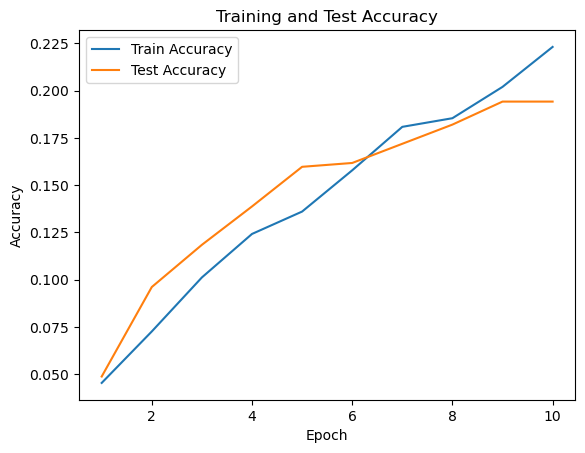

In [179]:
# PLOT THE ACCURACY on train and validation dataset
# --- Plot accuracy curves ---
plt.plot(range(1, num_epochs+1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracy')
plt.show()

What can you say about overfitting? What can be done to improve the accuracy of the model

## Optional: Calculate Top3 Accuracy

In this exercise, we were dealing with classification with quite high number of classes (35), so our result - around 50% validation accuracy - is pretty good. Standard ImageNet dataset has even more - 1000 classes.

In such cases it is difficult to ensure that model **always** correctly predicts the class. There are cases when two breeds are very similar to each other, and the model returns very similar probablities (eg., 0.45 and 0.43). If we measure standard accuracy, it will be considered a wrong case, even though the model did very small mistake. This, we often measure another metric - an accuracy within top 3 most probable predictions of the model.

We consider the case accurate if target label is contained within top 3 model predictions. 

To compute top-3 accuracy on the test dataset, you need to manually go over the dataset, apply the neural network to get the prediction, and then do the calculations. Some hints:

* In Tensorflow, use `tf.nn.in_top_k` function to see if the `predictions` (output of the model) are in top-k (pass `k=3` as parameter), with respect to `targets`. This function returns a tensor of boolean values, which can be converted to `int` using `tf.cast`, and then accumulated using `tf.reduce_sum`.
* In PyTorch, you can use `torch.topk` function to get indices of classes with highers probabilities, and then see if the correct class belongs to them. See [this](https://gist.github.com/weiaicunzai/2a5ae6eac6712c70bde0630f3e76b77b) for more hints.


In [181]:
# CALCULATE TOP-3 ACCURACY

def top_k_accuracy(model, dataloader, device, k=3):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs,labels in dataloader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, topk_indices = torch.topk(outputs, k, dim=1)

            labels = labels.view(-1, 1)
            correct += (topk_indices == labels).any(dim=1).sum().item()
            total += labels.size(0)
    
    return correct / total

top_k_accuracy(model, test_loader, device)

0.4133964817320704

## Optional: Build Cats vs. Dogs classification

We also want to see how accurate our binary cats vs. dogs classification would be on the same dateset. To do it, we need to adjust labels:

In [ ]:
# Define dataset that contains only two labels: 0 = cat, 1 = dog
# Hint: use class name prefix to figure out which one is which

In [ ]:
# Define neural network architecture and train